# Few Shot Learning Technique

In this Jupyter Notebook, we train a neural network with the few shot learning technique. This will be trained on a 68 instances of different monuments(8 different classes, where each class has 5-10 instances).
Then, it will be tested on a dataset of cards which contain images that the neural network did not see during training.

Few Shot learning technique is an object categorization technique, used mostly in computer vision. Most machine learning algorithms require thousands or tens of thousands of samples/images and large datasets in order to achieve good results, but few-shot learning learns information from only a few training samples/images.
This method was inspired by humans, which are able to learn many object categories just by seeing a few examples. The motivation is that systems, like humans, can use prior knowledge of object categories to classify new objects.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2 
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from random import sample

## 1. Dataset Creation

We create a dataset where we have two folders for training: trainImages1 and trainImages2, and two folders for validation validationImages1, validationImages2. Each of these folders have subfolders named 0 and 1. For example, the first image that is in trainImages1\1 is of the same class with the first image that is in trainImages2\1. This will enable the ImageDataGenerator to read pairs of images and know if they are of the same class(are in subfolders 1), or if they are of different classes(are in subfolders 0).
For testing, there is a csv file created where we have a pair of images and their corresponding label 0 or 1.

In [9]:
data_path = "\\dataset"
classes = ["Big_Ben", "Brandenburg_Gate", "Colosseo", "Duomo", "Eiffel", "Sagrada_familia",
           "Saint_Basil_Cathedral","Statue_of_liberty"]

In [10]:
Images = []
Labels = []

In [11]:
for i in range(0,len(classes)):
    dataset_path = "dataset\\"
    dataset_path = dataset_path + classes[i] + "\\"
    for image in glob.glob(dataset_path + "*.jpg"):
        opened_image = np.asarray(Image.open(image))
        opened_image = opened_image.reshape(67500,).tolist()
        Images.append(opened_image)
        Labels.append(i)

In [12]:
len(Images)

68

### 1.1 Training and Validation Samples

Create 40,000 pairs of images for training.

In [13]:
for i in range(0, 40000):
    images_chosen = sample(Images, 2)
    image_indexes = Images.index(images_chosen[0]), Images.index(images_chosen[1])
    image1 = np.asarray(images_chosen[0], dtype="uint8").reshape((150, 150, 3))
    image2 = np.asarray(images_chosen[1], dtype="uint8").reshape((150, 150, 3))
    if(Labels[image_indexes[0]] == Labels[image_indexes[1]]):
        plt.imsave(r"dataset\trainImages1\1\Image_one"+str(i)+".jpg", image1)
        plt.imsave(r"dataset\trainImages2\1\Image_two"+str(i)+".jpg", image2)
    else:
        plt.imsave(r"dataset\trainImages1\0\Image_one"+str(i)+".jpg", image1)
        plt.imsave(r"dataset\trainImages2\0\Image_two"+str(i)+".jpg", image2)

add some more pairs of images that are of the same class. This is done so that we don't end up having too many pairs of images of different classes, and too few of the images of the same class.

In [15]:
for i in range(40000, 80000):
    images_chosen = sample(Images, 2)
    image_indexes = Images.index(images_chosen[0]), Images.index(images_chosen[1])
    image1 = np.asarray(images_chosen[0], dtype="uint8").reshape((150, 150, 3))
    image2 = np.asarray(images_chosen[1], dtype="uint8").reshape((150, 150, 3))
    if(Labels[image_indexes[0]] == Labels[image_indexes[1]]):
        plt.imsave(r"dataset\trainImages1\1\Image_one"+str(i)+".jpg", image1)
        plt.imsave(r"dataset\trainImages2\1\Image_two"+str(i)+".jpg", image2)

Create 10,000 pairs of images for validation. Similar procedure as for the training images.

In [ ]:
for i in range(80000, 90000):
    images_chosen = sample(Images, 2)
    image_indexes = Images.index(images_chosen[0]), Images.index(images_chosen[1])
    image1 = np.asarray(images_chosen[0], dtype="uint8").reshape((150, 150, 3))
    image2 = np.asarray(images_chosen[1], dtype="uint8").reshape((150, 150, 3))
    if(Labels[image_indexes[0]] == Labels[image_indexes[1]]):
        plt.imsave(r"dataset\validationImages1\1\Image_one"+str(i)+".jpg", image1)
        plt.imsave(r"dataset\validationImages2\1\Image_two"+str(i)+".jpg", image2)
    else:
        plt.imsave(r"dataset\validationImages1\0\Image_one"+str(i)+".jpg", image1)
        plt.imsave(r"dataset\validationImages2\0\Image_two"+str(i)+".jpg", image2)

### 1.2 Testing Samples

Here, we have a csv file that contains three columns: Image_1, Image_2, Same.
Each row contains a pair of images and a value 0(if they are of different class), or 1 if they are of the same class.

In [37]:
test_dataset = open("test_dataset.csv", "r")
test_dataset.__next__()

'Image_1,Image_2,Same\n'

In [ ]:
testImages_1, testImages_2, testLabels = [], [], []
for row in test_dataset:
    bracket_index = row.index("]")
    image1 = row[1:bracket_index+1].strip("[]").split(",")
    image2 = row[bracket_index+4:-5].strip("[]").split(",")
    image1 = [int(i) for i in image1]
    image2 = [int(i) for i in image2]
    label = int(row[-2])
    image1_as_array, image2_as_array = np.array(image1, dtype="int"), np.array(image2, dtype="int") 
    image1_as_array, image2_as_array = image1_as_array.reshape((150, 150, 3)), image2_as_array.reshape((150, 150, 3))
    testImages_1.append(image1_as_array)
    testImages_2.append(image2_as_array)
    testLabels.append(label)

In [ ]:
testImages_1, testImages_2 = np.array(testImages_1), np.array(testImages_2)

In [ ]:
testLabels = np.asarray(testLabels).reshape((-1, 1))

## 2. Data Augmnetation

Creating a custom ImageDataGenerator for augmenting our input images.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
                                    rescale = 1 / 255.0,
                                    zoom_range = 0.1,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    rotation_range = 25,
                                    brightness_range = [0.6,1.3]
                                    )

validation_generator = ImageDataGenerator(
                                    rescale = 1 / 255.0,
                                    zoom_range = 0.1,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    rotation_range = 25,
                                    brightness_range = [0.6,1.3]
                                    )

def generate_generators(generator, dir1, dir2, batch_size):
    gen1 = generator.flow_from_directory(dir1,
                                         batch_size=batch_size,
                                         seed=7,
                                         class_mode='binary')
    
    gen2 = generator.flow_from_directory(dir2,
                                         batch_size=batch_size,
                                         seed=7,
                                         class_mode='binary')
    
    while True:
        image1 = gen1.next()
        image2 = gen2.next()
        yield [image1[0], image2[0]], image2[1]

In [ ]:
inputGenerator = generate_generators(generator=train_generator,
                                     dir1=traindir1,
                                     dir2=traindir2,
                                     batch_size=64)

validationGenerator = generate_generators(generator=validation_generator,
                                          dir1=validationdir1,
                                          dir2=validationdir2,
                                          batch_size=64)

## 3. Model

In [7]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Conv2D(filters=64, input_shape=(150, 150, 3), kernel_size=(5,5), strides=1, padding="same", kernel_initializer="he_normal", activation=tf.nn.leaky_relu),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=1, padding="same", kernel_initializer="he_normal", activation=tf.nn.leaky_relu),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", kernel_initializer="he_normal", activation=tf.nn.leaky_relu),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same", kernel_initializer="he_normal", activation=tf.nn.leaky_relu),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding="same", kernel_initializer="he_normal", activation=tf.nn.leaky_relu),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding="same", kernel_initializer="he_normal", activation=tf.nn.leaky_relu),
    layers.MaxPool2D(pool_size=2, strides=2),
    layers.Dropout(0.5)
])

avg = layers.GlobalAveragePooling2D()(model.output)
flatten = layers.Flatten()(avg)
output = layers.Dense(4096)(flatten)
model_2 = Model(inputs=model.input, outputs=output)

input_a = Input(shape=(150, 150, 3))
input_b = Input(shape=(150, 150, 3))
    
processed_a = model_2(input_a)
processed_b = model_2(input_b)

L1_layer = layers.Lambda(lambda tensors: tf.keras.backend.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([processed_a, processed_b])
prediction = layers.Dense(1, activation="sigmoid")(L1_distance)
final_model = Model(inputs=[input_a, input_b], outputs=prediction)

final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4096)         2266688     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           model[1][0]                

In [ ]:
# train final_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

opt = keras.optimizers.RMSprop(learning_rate=0.0001)
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=5)
mc = ModelCheckpoint('one_shot_learning_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
final_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [10]:
history = final_model.fit_generator(inputGenerator,
                          validation_data = validationGenerator,
                          steps_per_epoch = 920,
                          validation_steps = 156,
                          epochs=5,
                          callbacks=[mc, es])

Instructions for updating:
Please use Model.fit, which supports generators.
Found 58934 images belonging to 2 classes.
Found 58934 images belonging to 2 classes.
Epoch 1/5
920/920 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.7902Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
920/920 [==============================] - 2076s 2s/step - loss: 0.4069 - accuracy: 0.7902 - val_loss: 0.2146 - val_accuracy: 0.9019
Epoch 2/5
920/920 [==============================] - 2068s 2s/step - loss: 0.2205 - accuracy: 0.9035 - val_loss: 0.1745 - val_accuracy: 0.9232
Epoch 3/5
920/920 [==============================] - 2046s 2s/step - loss: 0.0730 - accuracy: 0.9739 - val_loss: 0.0879 - val_accuracy: 0.9629
Epoch 4/5
920/920 [==============================] - 2053s 2s/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 0.0877 - val_accuracy: 0.9668
Epoch 5/5
920/920 [==============================] - 2053s 2s/step - loss: 0.0166 - accuracy: 0.

## 4. Evaluation

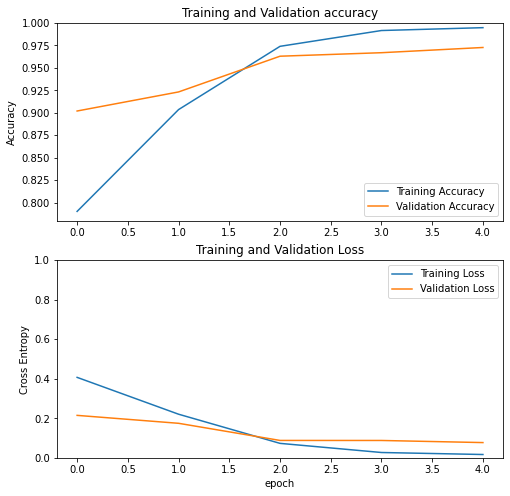

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 4. Testing

Testing is done with pairs of cards. These images were never seen before from the model during training. These test images are new instances of the monuments.
The model was able to predict correctly 84.65% of the time these 2,000 pairs of images.

In [43]:
final_model.evaluate([testImages_1, testImages_2], testLabels)

63/63 [==============================] - 4s 59ms/step - loss: 175.6844 - accuracy: 0.8465


[175.6844482421875, 0.8464999794960022]